# Classification and feature engineering

Exercise 1.

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(normal.shape[0]) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

hstack : 가로로 행렬 결합

ravel : 다차원을 1차원으로 바꿔줌

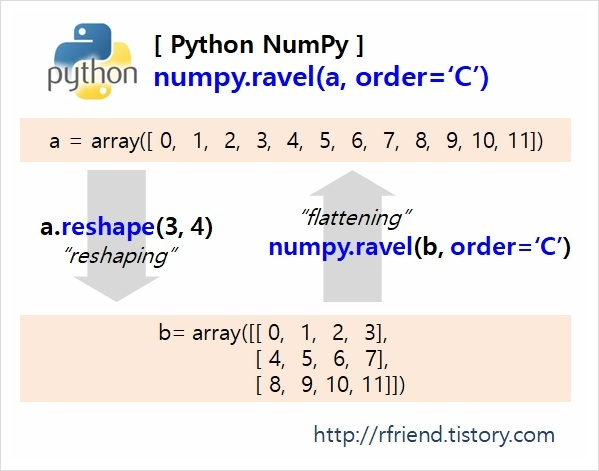

#출처 : https://rfriend.tistory.com/349

1..svg

In [ ]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

2..svg

In [ ]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

#accuracy : 0.55556

squeeze : 크기가 1인 axis 제거

ex) shape이 (1,3,3)일 때, (3,3)으로 변환해줌

-> [[1,2,3,4]] -> [1,2,3,4]같은 꼴


---


[사용방법]

ex) shape : (1,3,1,3)일 때 (2차원같이 보이나 실제로 4차원)

배열.squeeze() = (3,3)shape으로 변경

*Q : 일부 axis=1인 axis만 제거하고 싶다면?*

squeeze(axis=a)꼴로 axis지정해주되, 이 때 axis a의 값이 1이어야 작동함.

출처:https://jimmy-ai.tistory.com/101



Exercise 2.

In [ ]:
# Plot the raw data first
audio.plot(figsize=(10, 5))
plt.show()

3..svg

In [ ]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified.plot(figsize=(10, 5))
plt.show()

4..svg

In [ ]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
audio_rectified_smooth.plot(figsize=(10, 5))
plt.show()

5..svg

window 설정 후 rolling mean을 통해 smooth plot 구현

In [ ]:
# Calculate stats
means = np.mean(audio_rectified_smooth, axis=0)
print(means)
stds = np.std(audio_rectified_smooth, axis=0)
maxs = np.max(audio_rectified_smooth, axis=0)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5) #5-fold cv
print(np.mean(percent_score)) #0.716666667

In [ ]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None)) #lr.best.tempo를 통해 템포그램 추출.

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

Q : lr.best.tempo?

A : 분당 비트수인 템포를 추정해주는 함수.

i_audio.values : 오디오 시계열 / sr : 시계열의 sampling rate / hop_length : 시계열의 hop길이 / aggregate : None으로 설정 - 각 프레임에 대해 독립적으로 추정

출처 : https://librosa.org/doc/0.8.1/generated/librosa.beat.tempo.html

In [ ]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score)) #0.5

Q : tempogram이 무엇인가

Exercise 3.

In [ ]:
# Import the stft function
from librosa.core import stft


# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

In [ ]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec) #모든값이 양의 실수인지 확인
print(spec_db)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH) #스펙트로그램 생
plt.show()

6..svg

In [ ]:
import librosa as lr

# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

In [ ]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, ax=ax)
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

ax.fill_between : 수평방향의 곡선을 채움

출처 : https://wikidocs.net/92086

Q : 빈칸 채웠음에도 오류가 남

ax = specshow 파트를 ax object에 할당하지 않고 진행 => 오류

np.abs(spec) : QuadMesh 타입은 절대값취할 수 없음 -> 오류

=> 구글링해서 변경해도 'QuadMesh' object has no attribute 'plot'이라는 오류가 나옴.

In [ ]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)
    centroids.append(this_mean_centroid)

In [ ]:
# Create X and y arrays
X = np.column_stack([means, stds, maxs, tempo_mean, tempo_max, tempo_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score)) #0.48333

Q : 푸리에 변환?

A : 푸리에 변환은 시간이나 공간에서 샘플링된 신호를 시간 주파수 또는 공간 주파수에서 샘플링된 동일한 신호로 변환하는 수학적 공식 /  신호 처리에서 푸리에 변환은 신호의 중요한 특성, 즉 주파수 성분을 나타낼 수 있음

Q : 스펙트로그램 ?

A : 스펙트로그램(Spectrogram)은 소리나 파동을 시각화하여 파악하기 위한 도구로, 파형(waveform)과 스펙트럼(spectrum)의 특징이 조합되어 있다.

출처 : 구글링